
# ISIC 2024 - Skin Cancer Detection with 3D-TBP

Nicholas Kurtansky, Veronica Rotemberg, Maura Gillis, Kivanc Kose, Walter Reade, Ashley Chow. (2024). ISIC 2024 - Skin Cancer Detection with 3D-TBP. Kaggle. 

https://kaggle.com/competitions/isic-2024-challenge

Currently heavily in development.

In [165]:
import os
import os.path as path
import gc
import cv2
import math
import copy
import time
import random
import glob
import warnings

import h5py

from matplotlib import pyplot as plt
import seaborn as sns

from functools import partial

import numpy as np
import pandas as pd

# Pytorch
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# from torch.optim import lr_scheduler
# from torch.utils.data import Dataset, DataLoader
# from torch.cuda import amp
# import torchvision
# from torcheval.metrics.functional import binary_auroc

# Tensorflow 
import tensorflow as tf

# Sklearn 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold 

# import timm

# Albumentations
import albumentations as A
# from albumentations.pytorch import ToTensorV2

In [166]:
env_cfg = {
    "seed": 476,
    # "device": nn.device("cuda:0" if nn.cuda. else "cpu"),
    "device" : "GPU" if tf.config.list_physical_devices('GPU') else "CPU",
    "verbosity": '3',
}
CONFIG = {
    "seed": 42, 
    "img_size": 384,
    "model_name": "",
    "checkpoint_path" : "/ISIC2024_SkinCancerDetection/saved_models",
    
}

print(f"Using device: {env_cfg['device']}")

Using device: CPU


In [167]:
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = env_cfg["verbosity"]
os.environ['TF_CPP_MIN_LOG_LEVEL'] = env_cfg["verbosity"]

In [168]:
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".XX"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

tf.debugging.set_log_device_placement(False)

In [169]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [170]:
def set_seed(seed=42):

    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    tf.random.set_seed(seed)
    
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)
    
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
  
    # When running on the CuDNN backend, two further options must be set
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    
set_seed()

In [171]:
# https://www.kaggle.com/code/motono0223/isic-pytorch-training-baseline-image-only#Training-Function

ROOT_DIR = path.normpath("./data/")
TRAIN_DIR = f'{ROOT_DIR}/train-image/image/'

train_images = sorted(glob.glob(f"{TRAIN_DIR}/*.jpg"))
print(TRAIN_DIR)
print("Number of train_images:", len(train_images))

data/train-image/image/
Number of train_images: 401059


In [172]:
train_images[:5]

['data/train-image/image\\ISIC_0015670.jpg',
 'data/train-image/image\\ISIC_0015845.jpg',
 'data/train-image/image\\ISIC_0015864.jpg',
 'data/train-image/image\\ISIC_0015902.jpg',
 'data/train-image/image\\ISIC_0024200.jpg']

data/train-image/image//ISIC_0015864.jpg


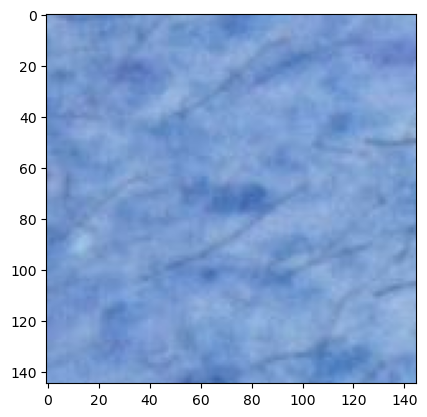

In [173]:
def get_train_file_path(image_id):
    return f"{TRAIN_DIR}/{image_id}.jpg"

print(get_train_file_path("ISIC_0015864"))
img = cv2.imread(get_train_file_path("ISIC_0015864"))

plt.imshow(img)

In [174]:
df = pd.read_csv(f"{ROOT_DIR}/train-metadata.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    398261 non-null  float64
 4   sex                           389542 non-null  object 
 5   anatom_site_general           395303 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A                      401059 non-null  float64
 10  tbp_lv_Aext                   401059 non-null  float64
 11  tbp_lv_B                      401059 non-null  float64
 12  tbp_lv_Bext                   401059 non-nul

In [175]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
isic_id,401059,401059,ISIC_0015670,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
target,401059.0,NaN,NaN,NaN,0.00098,0.031288,0.0,0.0,0.0,0.0,1.0
patient_id,401059,1042,IP_1117889,9184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age_approx,398261.0,NaN,NaN,NaN,58.012986,13.596165,5.0,50.0,60.0,70.0,85.0
sex,389542,2,male,265546,NaN,NaN,NaN,NaN,NaN,NaN,NaN
anatom_site_general,395303,5,posterior torso,121902,NaN,NaN,NaN,NaN,NaN,NaN,NaN
clin_size_long_diam_mm,401059.0,NaN,NaN,NaN,3.930827,1.743068,1.0,2.84,3.37,4.38,28.4
image_type,401059,1,TBP tile: close-up,401059,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tbp_tile_type,401059,2,3D: XP,285903,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tbp_lv_A,401059.0,NaN,NaN,NaN,19.974007,3.999489,-2.487115,17.330821,19.80191,22.304628,48.18961


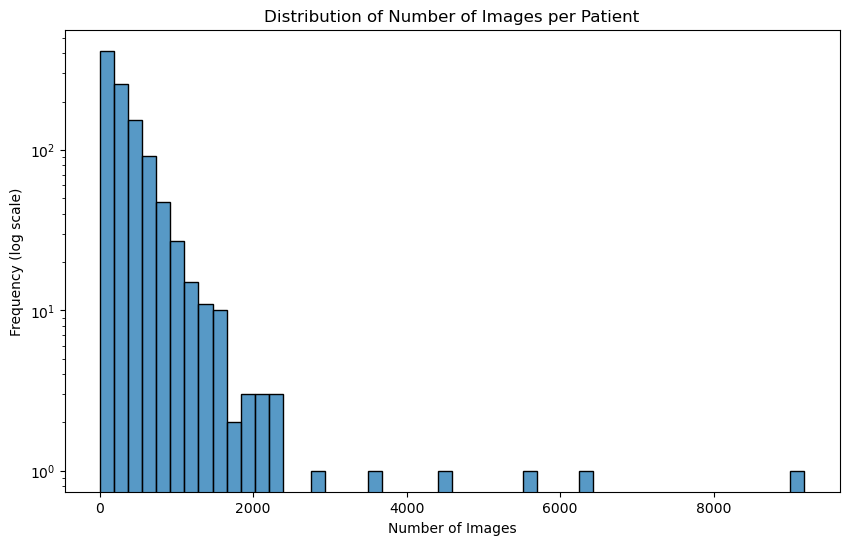

In [176]:
id_values = df["patient_id"].value_counts()

plt.figure(figsize=(10, 6))
sns.histplot(id_values, bins=50, kde=False)
plt.yscale('log')
plt.title('Distribution of Number of Images per Patient')
plt.xlabel('Number of Images')
plt.ylabel('Frequency (log scale)')
plt.show()

In [177]:
patient_with_most_images = id_values.idxmax()
most_images_count = id_values.max()

print(f"Patient ID with the most images: {patient_with_most_images}")
print(f"Number of images: {most_images_count}")

Patient ID with the most images: IP_1117889
Number of images: 9184


In [178]:
patient_with_most_images_entries = df[df.patient_id  == patient_with_most_images]
print(patient_with_most_images_entries)

             isic_id  target  patient_id  age_approx     sex  \
23      ISIC_0052122       0  IP_1117889        55.0  female   
47      ISIC_0073261       0  IP_1117889        55.0  female   
79      ISIC_0074118       0  IP_1117889        55.0  female   
104     ISIC_0075822       0  IP_1117889        55.0  female   
140     ISIC_0076635       0  IP_1117889        55.0  female   
...              ...     ...         ...         ...     ...   
400976  ISIC_9998037       0  IP_1117889        55.0  female   
401043  ISIC_9999596       0  IP_1117889        55.0  female   
401048  ISIC_9999779       0  IP_1117889        55.0  female   
401049  ISIC_9999817       0  IP_1117889        55.0  female   
401050  ISIC_9999852       0  IP_1117889        55.0  female   

       anatom_site_general  clin_size_long_diam_mm          image_type  \
23          anterior torso                    2.60  TBP tile: close-up   
47          anterior torso                    6.19  TBP tile: close-up   
79       

In [179]:
df_positive = df[df["target"] == 1].reset_index(drop=True)
df_negative = df[df["target"] == 0].reset_index(drop=True)

print("Unique patients:",  df["patient_id"].unique().shape[0])
print()

print("Positive patient images:", df_positive.shape[0])
print("Unique patients with positive images:",  df_positive["patient_id"].unique().shape[0])
print()

print("Negative patient images:", df_negative.shape[0])
print("Unique patients with negative images:",  df_negative["patient_id"].unique().shape[0])

Unique patients: 1042

Positive patient images: 393
Unique patients with positive images: 259

Negative patient images: 400666
Unique patients with negative images: 1041


In [180]:
# Imbalanced dataset fix

df = pd.concat([df_positive, df_negative.iloc[:df_positive.shape[0]*7, :]])  
print("Reduced dataset shape:", df.shape, df.target.sum(), df["patient_id"].unique().shape)

df['file_path'] = df['isic_id'].apply(get_train_file_path)

# df = df[ df["file_path"].isin(train_images) ].reset_index(drop=True)

df.head()

Reduced dataset shape: (3144, 55) 393 (788,)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,file_path
0,ISIC_0082829,1,IP_3249371,80.0,female,anterior torso,9.27,TBP tile: close-up,3D: XP,18.093368,...,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,Squamous cell carcinoma in situ,NaN,NaN,NaN,NaN,72.211683,data/train-image/image//ISIC_0082829.jpg
1,ISIC_0096034,1,IP_6723298,75.0,male,head/neck,3.88,TBP tile: close-up,3D: white,26.187010,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,94.559590,data/train-image/image//ISIC_0096034.jpg
2,ISIC_0104229,1,IP_9057861,80.0,male,anterior torso,6.55,TBP tile: close-up,3D: white,33.480140,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,66.196170,data/train-image/image//ISIC_0104229.jpg
3,ISIC_0119495,1,IP_6856511,60.0,male,upper extremity,5.27,TBP tile: close-up,3D: white,25.872050,...,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,"Squamous cell carcinoma, Invasive",NaN,NaN,NaN,NaN,99.991270,data/train-image/image//ISIC_0119495.jpg
4,ISIC_0157834,1,IP_3927284,55.0,male,posterior torso,5.29,TBP tile: close-up,3D: white,30.966662,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Superficial",NaN,NaN,NaN,99.960846,data/train-image/image//ISIC_0157834.jpg


In [181]:
print("Number of unique patients after balancing: ", df["patient_id"].nunique())

Number of unique patients after balancing:  788


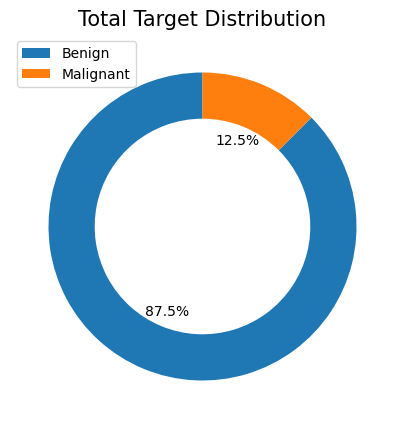

In [182]:
name = ['Benign', 'Malignant']

plt.figure(figsize = (5, 5))
plt.pie(df.target.value_counts(normalize = True), autopct = '%1.1f%%', startangle = 90, wedgeprops = dict(width = 0.3), 
        labeldistance = 1.2, radius = 1)
plt.title(f'Total Target Distribution', color = 'black', fontsize = 15)
plt.legend(name,)

plt.show()

In [183]:
missing_values_count = df.isnull().sum()
print(sorted(missing_values_count, reverse=True))

[3144, 3091, 3081, 2901, 2745, 2745, 2591, 100, 25, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [184]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Downscale(p=0.25),
        A.ShiftScaleRotate(shift_limit=0.1, 
                           scale_limit=0.15, 
                           rotate_limit=60, 
                           p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        # ToTensorV2()
    ], p=1.),
    
    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        # ToTensorV2()
    ], p=1.)
}


In [185]:
def aug_fn(image, img_size, train):
    data = {"image":image}
    aug_data = data_transforms(**data["train" if train else "valid"])
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    return tf.image.resize(aug_img, size=[img_size, img_size])

In [186]:
def process_data(image, img_size):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
    return aug_img

In [187]:
# Manual loading, too slow
# x_train = []
# y_train = []
# with h5py.File('ISIC2024_SkinCancerDetection/data/train-image.hdf5', 'r') as f:
#        keys = list(f.keys())
#        for key in keys:
#            data = f[key]
#            x_train.append(data[()].decode('latin-1'))
#            
#            # x_train.append(f[key][:]) 
#            y_train.append(key)
#               
# print(len(x_train), len(y_train))
# print(x_train[:5], y_train[:5])

In [188]:
training_validation_hdf5 = h5py.File(f"{ROOT_DIR}/train-image.hdf5", 'r')

First image shape: (129, 129, 3).


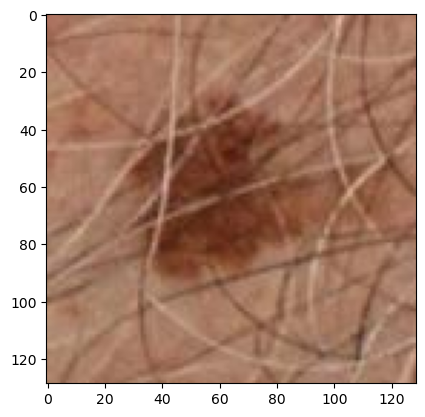

In [229]:
# Example

isic_id = df.isic_id.iloc[10]

byte_string = training_validation_hdf5[isic_id][()]
# print(f"Byte String: {byte_string[:20]}....")

nparr = np.frombuffer(byte_string, np.uint8)

image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)[...,::-1] # reverse last axis for bgr -> rgb
#print(f"Image: {image}")

plt.imshow(image);
print(f"First image shape: {image.shape}.")

In [190]:
# Load all images

data_ids = df.isic_id.values

images = [None]*len(data_ids)
for i, isic_id in enumerate(data_ids):
    images[i] = training_validation_hdf5[isic_id][()]

print(f"Loaded {len(images)} images.")

Loaded 3144 images.
First image shape: (137, 137, 3).


In [191]:
mg = []

# import concurrent.futures
# from PIL import Image

# def load_and_convert_image(image_path):
#     # img = cv2.imread(image_path)
#     # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     # return img
#     with Image.open(image_path) as img:
#         img = img.convert('RGB')
#         img = img.resize((CONFIG["img_size"], CONFIG["img_size"]))
#         return np.array(img)

# with concurrent.futures.ThreadPoolExecutor() as executor:
#     mg = list(executor.map(load_and_convert_image, train_images))

# print(f"Loaded {len(mg)} images.")
# print(f"First image shape: {mg[0].shape}.")
# print(f"First image: {mg[0]}.")

In [192]:
# hist = [cv2.calcHist([cv2.imdecode(np.frombuffer(img, np.uint8), cv2.IMREAD_COLOR)], [0], None, [256], [0, 256]) for img in images]
# hist = np.array(hist).squeeze()
# plt.plot(hist[0], label="Blue")

In [193]:
# Based on https://www.kaggle.com/code/awsaf49/isic2024-kerascv-starter

def decoder(only_image=False, with_labels=True, target_size=(256, 256)):
    
    def decode_only_image(file_bytes, label):
        
        image = tf.io.decode_jpeg(file_bytes)
        
        image = tf.image.resize(image, size=target_size, method="area")
        
        image = tf.cast(image, tf.float32)
        image /= 255.0
  
        image = tf.reshape(image, [*target_size, 3])
        
        return image, label
    
    def decode_image(inp):
        
        file_bytes = inp["images"]
        image = tf.io.decode_jpeg(file_bytes)
        
        image = tf.image.resize(image, size=target_size, method="area")
        
        image = tf.cast(image, tf.float32)
        image /= 255.0
  
        image = tf.reshape(image, [*target_size, 3])
        
        inp["images"] = image
        return inp
    
    
    def decode_label(label, num_classes):
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [num_classes])
        return label
    
  
    def decode_with_labels(inp, label=None):
        inp = decode_image(inp)
        label = decode_label(label, 1)
        return inp, label
    
    if only_image:
        return decode_only_image
    return decode_with_labels if with_labels else decode_image

multi_decoder = decoder(with_labels=False, target_size=(CONFIG["img_size"], CONFIG["img_size"]))
image_decoder = decoder(only_image=True, with_labels=False, target_size=(CONFIG["img_size"], CONFIG["img_size"]))

In [194]:
# Too slow
# decoded_images = [cv2.imdecode(np.frombuffer(img, np.uint8), cv2.IMREAD_COLOR)[...,::-1] for img in images]

In [195]:
# Multimodal dataset

# inp = {
#     "images": images, 
#     "features": features
#        }

# slices = (inp, df.target.values)

# ds = tf.data.Dataset.from_tensor_slices(slices)
 
# ds = tf.data.Dataset.from_tensor_slices(images, df.target.values)
# ds = ds.cache()
# ds = ds.map(decoder, num_parallel_calls=AUTOTUNE)

# ds = ds.shuffle(1024, seed=seed)
# opt = tf.data.Options()
# opt.deterministic = False
# ds = ds.with_options(opt)

# ds = ds.batch(CONFIG['train_batch_size'], drop_remainder=True)

# ds = ds.map(augment_fn, num_parallel_calls=AUTOTUNE)
# ds = ds.prefetch(AUTOTUNE)

In [196]:
# ds.cardinality()

In [197]:
# Manual decoding, too slow

# decoded_images = []
# target_size=(CONFIG["img_size"], CONFIG["img_size"])
# 
# for file_bytes in images:
#     with tf.device("/CPU:0"):
#         image = tf.io.decode_jpeg(file_bytes)
# 
#         image = tf.image.resize(image, size=target_size, method="area")
# 
#         image = tf.cast(image, tf.float32)
#         image /= 255.0
# 
#         image = tf.reshape(image, [*target_size, 3])
# 
#         decoded_images.append(image)
# 
# decoded_images = tf.stack(decoded_images)
# 
# decoded_images_np = decoded_images.numpy()
# 
# 
# print(decoded_images_np.shape)

In [206]:
# Hyperparameters 

# activation_func = 'gelu'
activation_func = 'relu'
# activation_func = 'mish'
batch_size = 16
num_epochs = 50
learning_rate = 3e-4
criterion = tf.keras.losses.BinaryCrossentropy()
# criterion = tf.keras.losses.MeanAbsoluteError()
# criterion = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-5)

initializer = tf.keras.initializers.GlorotUniform(seed=CONFIG["seed"])

In [207]:
# Single image dataset

dataset = tf.data.Dataset.from_tensor_slices((images, df.target.values))

ds_size = dataset.cardinality().numpy()

dataset = dataset.cache()

dataset = dataset.map(image_decoder, num_parallel_calls=AUTOTUNE)

# dataset = dataset.shuffle(buffer_size=ds_size)

# Split the dataset into training and validation sets
train_ds, valid_ds = tf.keras.utils.split_dataset(dataset, left_size=0.9, shuffle=True, seed=42)

# train_size = int(0.8 * ds_size)
# train_ds = dataset.take(train_size)
# valid_ds = dataset.skip(train_size)

# Apply batching
train_ds = train_ds.batch(batch_size=batch_size, drop_remainder=True)
valid_ds = valid_ds.batch(batch_size=batch_size, drop_remainder=True)

# Apply augmentation
# train_ds = train_ds.map(augment_fn, num_parallel_calls=AUTOTUNE)

# Prefetch to improve performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)

print(f"Training dataset size: {train_ds.cardinality().numpy()}")
print(f"Validation dataset size: {valid_ds.cardinality().numpy()}")

Training dataset size: 176
Validation dataset size: 19


In [200]:
# Sanity check

train_data_check, train_labels_check = [], []
valid_data_check, valid_labels_check = [], []

for img, label in train_ds.unbatch().as_numpy_iterator():
    train_data_check.append(img)
    train_labels_check.append(label)
    
for img, label in valid_ds.unbatch().as_numpy_iterator():
    valid_data_check.append(img)
    valid_labels_check.append(label)
    
# train_data_check, train_labels_check =  train_ds.unbatch().as_numpy_iterator()
# valid_data_check, valid_labels_check = valid_ds.unbatch().as_numpy_iterator()

# train_data_flattened_check = np.array([x.flatten() for x in train_data_check])
# valid_data_flattened_check = np.array([x.flatten() for x in valid_data_check])

duplicates = 0
# Check for duplicates
for train_img in train_data_check:
    for valid_img in valid_data_check:
        if np.array_equal(train_img, valid_img):
            duplicates += 1
            break

print(f"Number of duplicates: {duplicates}")

del train_data_check, train_labels_check, valid_data_check, valid_labels_check

Number of duplicates: 0


In [201]:
train_c = 0
val_c = 0

for batch in train_ds:
    train_c += sum(batch[1])

for batch in valid_ds:
    val_c += sum(batch[1])

print(train_c, val_c)

tf.Tensor(349, shape=(), dtype=int64) tf.Tensor(42, shape=(), dtype=int64)


In [208]:
class Net(tf.keras.Model):
    def __init__(self):
        super(Net, self).__init__()
        
        #self.flatten_layer = keras.layers.Flatten(name="flatten")

        self.conv1 = tf.keras.layers.Conv2D(filters=8, kernel_size=(4, 4), 
                                            input_shape=(batch_size, 384, 384, 3),
                                            activation=activation_func
                                            )
        self.pool1 = (tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        self.conv2 = tf.keras.layers.Conv2D(filters=16, kernel_size=(4, 4), 
                                            activation=activation_func, 
                                            # strides=(2, 2)
                                            )
        self.pool2 = (tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        self.conv3 = tf.keras.layers.Conv2D(filters=32, kernel_size=(4, 4),
                                            activation=activation_func,
                                            # strides=(2, 2)
                                            )
        self.pool3 = (tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        self.conv4 = tf.keras.layers.Conv2D(filters=64, kernel_size=(4, 4),
                                            activation=activation_func
                                            )
        self.pool4 = (tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        self.conv5 = tf.keras.layers.Conv2D(filters=128, kernel_size=(4, 4),
                                            activation=activation_func
                                            )
        self.pool5 = (tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        self.conv6 = tf.keras.layers.Conv2D(filters=256, kernel_size=(4, 4),
                                            activation=activation_func
                                            )
        self.pool6 = (tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        self.flatten = tf.keras.layers.Flatten()
    

        # self.feature_extractor = []
        # for i in range(5):
        #     self.hidden_layers.append(tf.keras.layers.Dense(2048, activation=activation_func))
        #     self.hidden_layers.append(tf.keras.layers.Dropout(0.2))

        self.hidden_layers = []
        for i in range(1):
            self.hidden_layers.append(tf.keras.layers.Dense(256, activation=activation_func))
            # self.hidden_layers.append(tf.keras.layers.Dropout(0.2))
            self.hidden_layers.append(tf.keras.layers.BatchNormalization())


        self.additional_layers = []
        for i in range(1):
            self.additional_layers.append(tf.keras.layers.Dense(128, activation=activation_func))
            # self.hidden_layers.append(tf.keras.layers.BatchNormalization())

        self.output_layer = tf.keras.layers.Dense(1, activation='sigmoid')


    def call(self, x):
        #x = self.flatten_layer(x)
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.pool4(x)
        x = self.conv5(x)
        x = self.pool5(x)
        x = self.conv6(x)
        x = self.pool6(x)

        x = self.flatten(x)
        
        # for layer in self.feature_extractor:
        #     x = layer(x)

        for layer in self.hidden_layers:
            x = layer(x)

        for layer in self.additional_layers:
            x = layer(x)

        return self.output_layer(x)

model = Net()

In [209]:
#Callbacks

callbacks = []
callbacks.append(tf.keras.callbacks.TensorBoard(log_dir=f"{ROOT_DIR}/logs",
                                                histogram_freq=0,
                                                write_steps_per_second=True,
                                                write_images=False,
                                                )
                 )

callbacks.append(tf.keras.callbacks.ProgbarLogger())

In [210]:
model.compile(optimizer=optimizer, loss=criterion, metrics=['accuracy'])

In [211]:
history = model.fit(train_ds, epochs=num_epochs, validation_data=valid_ds, callbacks=callbacks)

Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 80s 397ms/step - accuracy: 0.8832 - loss: 0.4236 - val_accuracy: 0.8914 - val_loss: 0.3138
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 68s 384ms/step - accuracy: 0.8894 - loss: 0.3333 - val_accuracy: 0.8882 - val_loss: 0.2936
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 67s 382ms/step - accuracy: 0.8948 - loss: 0.2801 - val_accuracy: 0.9013 - val_loss: 0.2948
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 67s 383ms/step - accuracy: 0.9003 - loss: 0.2647 - val_accuracy: 0.8980 - val_loss: 0.2905
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 67s 383ms/step - accuracy: 0.9014 - loss: 0.2581 - val_accuracy: 0.8980 - val_loss: 0.2884
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 68s 384ms/step - accuracy: 0.9044 - loss: 0.2529 - val_accuracy: 0.9013 - val_loss: 0.2872
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 67s 382ms/step - accuracy: 0.9071 - loss: 0.2485 - val_accuracy: 0.9013 - val_loss: 0.2863
Epoch 8/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 67s 383ms/step - accuracy: 0.9104 - loss: 0

In [212]:
model.summary()

Model: "net_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (16, 381, 381, 8)      │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_26            │ ?                      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (16, 187, 187, 16)     │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_27            │ ?                      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (16, 90, 90, 32)       │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_28            │ ?                      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (16, 42, 42, 64)       │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_29            │ ?                      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (16, 18, 18, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_30            │ ?                      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (16, 6, 6, 256)        │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_31            │ ?                      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (16, 2304)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (16, 256)              │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (16, 256)              │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (16, 128)              │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (16, 1)                │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,969,133 (15.14 MB)

 Trainable params: 1,322,873 (5.05 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 2,645,748 (10.09 MB)

In [228]:
# Testing

test_hdf5 = h5py.File(f"{ROOT_DIR}/test-image.hdf5", 'r')

test_images = [None]*len(data_ids)
test_labels = [None]*len(data_ids)

for i, isic_id in enumerate(data_ids):
    if isic_id in test_hdf5:
        if test_hdf5[isic_id][()] is not None:
            test_images[i] = test_hdf5[isic_id][()]
            test_labels[i] = df[isic_id].target

print(f"Loaded {len(images)} images.")
print(f"First image shape: {cv2.imdecode(np.frombuffer(images[0], np.uint8), cv2.IMREAD_COLOR).shape}.")

for i, img in enumerate(test_images):
    if img is None or not img:
        print(f"Image {i} is None.")
        test_images.remove(test_images[i])
        test_labels.remove(test_labels[i])
        
print(f"Loaded {len(images)} images.")

test_dataset = tf.data.Dataset.from_tensor_slices(test_images, test_labels)

test_dataset = test_dataset.cache()

test_dataset = test_dataset.map(image_decoder, num_parallel_calls=AUTOTUNE)

test_dataset = test_dataset.batch(batch_size=batch_size, drop_remainder=True)

test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

print(f"Testing dataset size: {test_dataset.cardinality().numpy()}")


predictions = model.predict(test_dataset)

predictions

Loaded 3144 images.
First image shape: (137, 137, 3).
Image 0 is None.
Image 1 is None.
Image 2 is None.
Image 3 is None.
Image 4 is None.
Image 5 is None.
Image 6 is None.
Image 7 is None.
Image 8 is None.
Image 9 is None.
Image 10 is None.
Image 11 is None.
Image 12 is None.
Image 13 is None.
Image 14 is None.
Image 15 is None.
Image 16 is None.
Image 17 is None.
Image 18 is None.
Image 19 is None.
Image 20 is None.
Image 21 is None.
Image 22 is None.
Image 23 is None.
Image 24 is None.
Image 25 is None.
Image 26 is None.
Image 27 is None.
Image 28 is None.
Image 29 is None.
Image 30 is None.
Image 31 is None.
Image 32 is None.
Image 33 is None.
Image 34 is None.
Image 35 is None.
Image 36 is None.
Image 37 is None.
Image 38 is None.
Image 39 is None.
Image 40 is None.
Image 41 is None.
Image 42 is None.
Image 43 is None.
Image 44 is None.
Image 45 is None.
Image 46 is None.
Image 47 is None.
Image 48 is None.
Image 49 is None.
Image 50 is None.
Image 51 is None.
Image 52 is None.
Im

ValueError: Invalid `element`. `element` should not be empty.

In [43]:
# Submission

image_ids = []
predictions = []

with h5py.File("I/SIC2024_SkinCancerDetection/data/test-image.hdf5", 'r') as hdf:
    for key in hdf.keys():
        dataset = hdf[key]
        if isinstance(dataset, h5py.Dataset):
            
            img_data = dataset[()]
            img_data = np.frombuffer(img_data, dtype=np.uint8)
            img = Image.open(io.BytesIO(img_data))

            img = test_transform(img)

            img = img.unsqueeze(0).to(CONFIG['device']) 

            output = model(img)
            # probability = output.squeeze().cpu().item()

            image_ids.append(key)
            predictions.append(output)

submission_df = pd.DataFrame({
    'isic_id': image_ids,
    'target': predictions 
})

submission_df.to_csv('submission.csv', index=False)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'I/SIC2024_SkinCancerDetection/data/test-image.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# TODO: Custom training loop with evaluation



In [ ]:


x_train_tensor = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_test_tensor = tf.convert_to_tensor(x_test, dtype=tf.float32)

y_train_pred = model(x_train_tensor, training=False).numpy()
y_test_pred = model(x_test_tensor, training=False).numpy()

In [ ]:
# construct a plot that plots and saves the training history
N = np.arange(0, NUM_EPOCHS)

plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])

In [ ]:
# Transfer Learning [freeze all layers of feature extractor]: Functional API

base_model = keras.applications.ResNet50(include_top=False, input_shape=(CONFIG["img_size"], CONFIG["img_size"], 3), weights="imagenet")
base_model.trainable = False

class MyModel(keras.Model):
    def __init__(self, base_model):
        super(MyModel, self).__init__()
        self.base = base_model
        self.layer_1 = keras.layers.Flatten()
        self.layer_2 = keras.layers.Dense(64, activation='relu')
        self.layer_3 = keras.layers.Dense(1, activation='softmax')

    @tf.function
    def call(self, xb):
        x = self.base(xb)
        x = self.layer_1(x)
        x = self.layer_2(x)
        return self.layer_3(x)


model = MyModel(base_model=base_model)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

model.fit(train_data, epochs=2)